In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
from tqdm.auto import tqdm, trange
import xgboost as xgb
import joblib
from sklearn.model_selection import cross_validate

from src.model import tscv, ClippedOutputRegressor
from src.feature_engineering import get_feature_cols, df_to_X_y, drop_non_features

%run constants.py

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.1
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2


Firstly let's load the model we'll be using for our test. I'll be using the baseline model so we have a good comparison with the logged results.

In [2]:
baseline_reg = joblib.load(os.path.join(MODELS_DIR, 'xgb-baseline.model'))

Now some functions that will help us.

In [21]:
def scores_df(scores):
    return pd.DataFrame({
        'test_score_mean': [np.mean(s['test_score']) for s in scores],
        'test_score_std': [np.std(s['test_score']) for s in scores],
        'test_score_last_fold': [s['test_score'][-1] for s in scores]
    })

def plt_scores(scores_df):
    df = scores_df.copy()
    df['idx'] = df.index
    df = df.melt(value_vars=['test_score_mean', 'test_score_last_fold'], id_vars=['idx'],value_name='neg_RMSE')
    sns.lineplot(data=df, x='idx', y='neg_RMSE', hue='variable')
    
def validate(df, reg_val=baseline_reg, verbose=2, cv_splits=None):
    if not cv_splits:
        cv_splits = tscv.split(df['date_block_num'])
    X_train, y_train = df_to_X_y(df)
    scores = cross_validate(reg_val, X=X_train, y=y_train, 
                            cv=cv_splits, 
                            scoring='neg_root_mean_squared_error', verbose=verbose)
    print("RMSE: %.5f (+- %.5f)" % (np.mean(scores['test_score']), np.std(scores['test_score'])))
    return scores

# Lagged item selection

I'm confident the item counts are highly correlated. Maybe reducing the number of months we get the counts from might help.

In [5]:
train_set_002 = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'train-set-features-002.parquet'))
train_set_002.columns

Index(['item_id', 'shop_id', 'date_block_num', 'item_cnt_month',
       'f__item_cnt_1', 'f__item_cnt_2', 'f__item_cnt_3', 'f__item_cnt_4',
       'f__item_cnt_5', 'f__item_cnt_6', 'f__item_cnt_7', 'f__item_cnt_8',
       'f__item_cnt_9', 'f__item_cnt_10', 'f__item_cnt_11', 'f__item_cnt_12',
       'f__item_cnt_13', 'f__item_cnt_14', 'f__item_cnt_15', 'f__item_cnt_16',
       'f__item_cnt_17', 'f__item_cnt_18', 'f__item_cnt_19', 'f__item_cnt_20',
       'f__item_cnt_21', 'f__item_cnt_22', 'f__item_cnt_23', 'f__item_cnt_24',
       'f__item_cnt_25', 'f__item_cnt_26', 'f__item_cnt_27', 'f__item_cnt_28',
       'f__item_cnt_29', 'f__item_cnt_30', 'f__item_cnt_31', 'f__item_cnt_32'],
      dtype='object')

Let's check for the correlation.

In [6]:
def corr_plot(corr_mat, figsize=(10, 10)):
    _, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr_mat, mask=np.triu(np.ones_like(corr_mat, dtype=np.bool)),
                square=True, linewidths=.1, cbar_kws={"shrink": .5}, 
                ax=ax, center=0, vmin=-1, vmax=1)

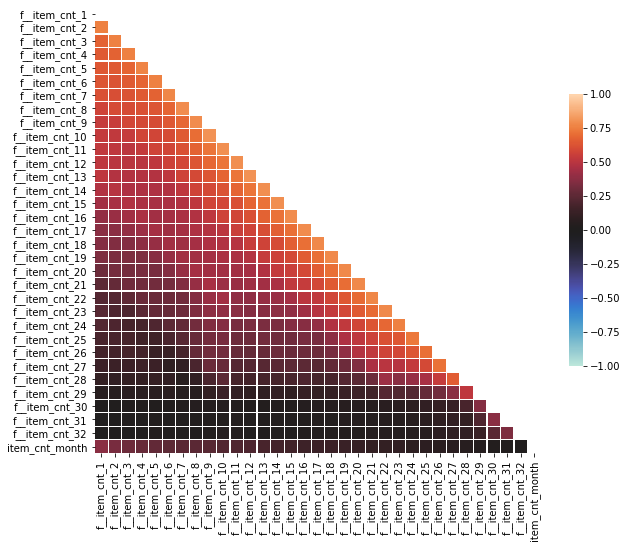

In [15]:
features_corr = train_set_002[np.append(get_feature_cols(train_set_002), ['item_cnt_month'])].corr()
corr_plot(features_corr, figsize=(10, 10))

As expected, a lot of correlation. Let's plot the relationship between validation score and lag window size.

In [17]:
item_cnt_scores = [validate(train_set_002.drop(columns=['f__item_cnt_%d' % i 
                                                        for i in range(lag_lim, 33)]),
                            verbose=0)
                   for lag_lim in trange(2, 33)]

RMSE: -0.89806 (+- 0.05576)
RMSE: -0.88053 (+- 0.06095)
RMSE: -0.87241 (+- 0.06147)
RMSE: -0.87017 (+- 0.06287)
RMSE: -0.86863 (+- 0.06206)
RMSE: -0.86712 (+- 0.06064)
RMSE: -0.86605 (+- 0.06068)
RMSE: -0.86542 (+- 0.06191)
RMSE: -0.86511 (+- 0.06311)
RMSE: -0.86599 (+- 0.06256)
RMSE: -0.86468 (+- 0.06297)


KeyboardInterrupt: 

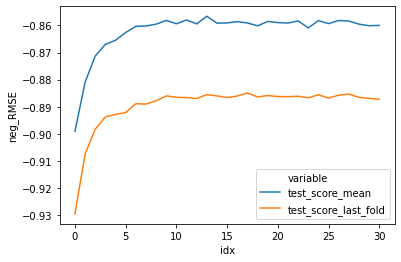

In [52]:
plt_scores(scores_df(item_cnt_scores))

It improves until around 8, but then it doesn't change much. There's also some peaks which indicate some months do add value, so let's try a different approach: for each month, let's validate the dataset without it and see if it improves or not.

In [19]:
item_cnt_drop_scores = [validate(train_set_002.drop(columns=['f__item_cnt_%d' % i]),
                                 verbose=0)
                        for i in trange(1, 33)]

RMSE: -0.91603 (+- 0.07258)
RMSE: -0.87218 (+- 0.06073)
RMSE: -0.86884 (+- 0.06286)
RMSE: -0.86766 (+- 0.06375)
RMSE: -0.86806 (+- 0.06326)
RMSE: -0.86687 (+- 0.06183)
RMSE: -0.86715 (+- 0.06302)
RMSE: -0.86602 (+- 0.06353)
RMSE: -0.86626 (+- 0.06245)
RMSE: -0.86668 (+- 0.06291)
RMSE: -0.86906 (+- 0.06263)
RMSE: -0.86694 (+- 0.06368)
RMSE: -0.86769 (+- 0.06261)
RMSE: -0.86752 (+- 0.06203)
RMSE: -0.86722 (+- 0.06363)
RMSE: -0.86711 (+- 0.06332)
RMSE: -0.86704 (+- 0.06349)
RMSE: -0.86692 (+- 0.06489)
RMSE: -0.86721 (+- 0.06258)
RMSE: -0.86660 (+- 0.06312)
RMSE: -0.86738 (+- 0.06199)
RMSE: -0.86667 (+- 0.06467)
RMSE: -0.86534 (+- 0.06414)
RMSE: -0.86642 (+- 0.06424)
RMSE: -0.86719 (+- 0.06205)
RMSE: -0.86651 (+- 0.06415)
RMSE: -0.86771 (+- 0.06390)
RMSE: -0.86647 (+- 0.06359)
RMSE: -0.86769 (+- 0.06265)
RMSE: -0.86687 (+- 0.06299)
RMSE: -0.86762 (+- 0.06277)
RMSE: -0.86756 (+- 0.06264)



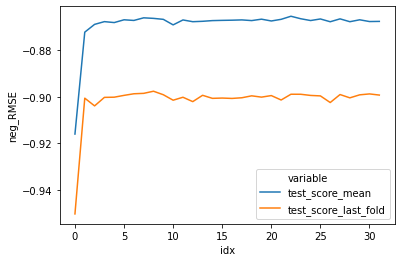

In [22]:
plt_scores(scores_df(item_cnt_drop_scores))

In [30]:
original_score = -0.86796
eps = 0.001
cols_to_drop = [i for i, s in enumerate(item_cnt_drop_scores) if np.mean(s['test_score']) > original_score + eps]

In [31]:
cols_to_drop

[5, 7, 8, 9, 11, 17, 19, 21, 22, 23, 25, 27, 29]

In [32]:
validate(train_set_002.drop(columns=['f__item_cnt_%d' % i for i in cols_to_drop]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  10.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV] ................................................. , total=  12.5s
[CV]  ................................................................
[CV] ................................................. , total=  11.3s
RMSE: -0.86678 (+- 0.06347)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.2s finished


{'fit_time': array([ 9.60526013, 11.65860653, 10.54394102]),
 'score_time': array([0.82388425, 0.80268669, 0.77384043]),
 'test_score': array([-0.77791414, -0.92215417, -0.90026053])}

That's a reeeally tiny improvement, but I'll take it. The other advantage is this reduces the size of the feature set dramatically.

# Time window selection

Let's first check if the time window we use to train is optimal. We'll do this by selecting the one that yields the best CV score (which means we will basically treat it as an extra hyperparameter).

In [4]:
X_train, y_train = df_to_X_y(train_set_005)
windows_scores = [cross_validate(reg_cv, X=X_train, y=y_train, 
                                 cv=tscv.split(train_set['date_block_num'], 
                                               window=w), 
                                 scoring='neg_root_mean_squared_error', 
                                 verbose=0)
                 for w in tqdm(range(1, 32))]

NameError: name 'train_set_005' is not defined

<AxesSubplot:>

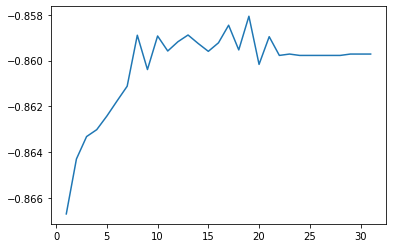

In [9]:
sns.lineplot(x=list(range(1, 32)), y=[s['test_score'].mean() for s in windows_scores])

Ok, we can see it's good to use all the data, so let's get back to feature selection.

# Correlation between features

In [22]:
def corr_plot(corr_mat, figsize=(10, 10)):
    _, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr_mat, mask=np.triu(np.ones_like(corr_mat, dtype=np.bool)),
                square=True, linewidths=.1, cbar_kws={"shrink": .5}, 
                ax=ax, center=0, vmin=-1, vmax=1)

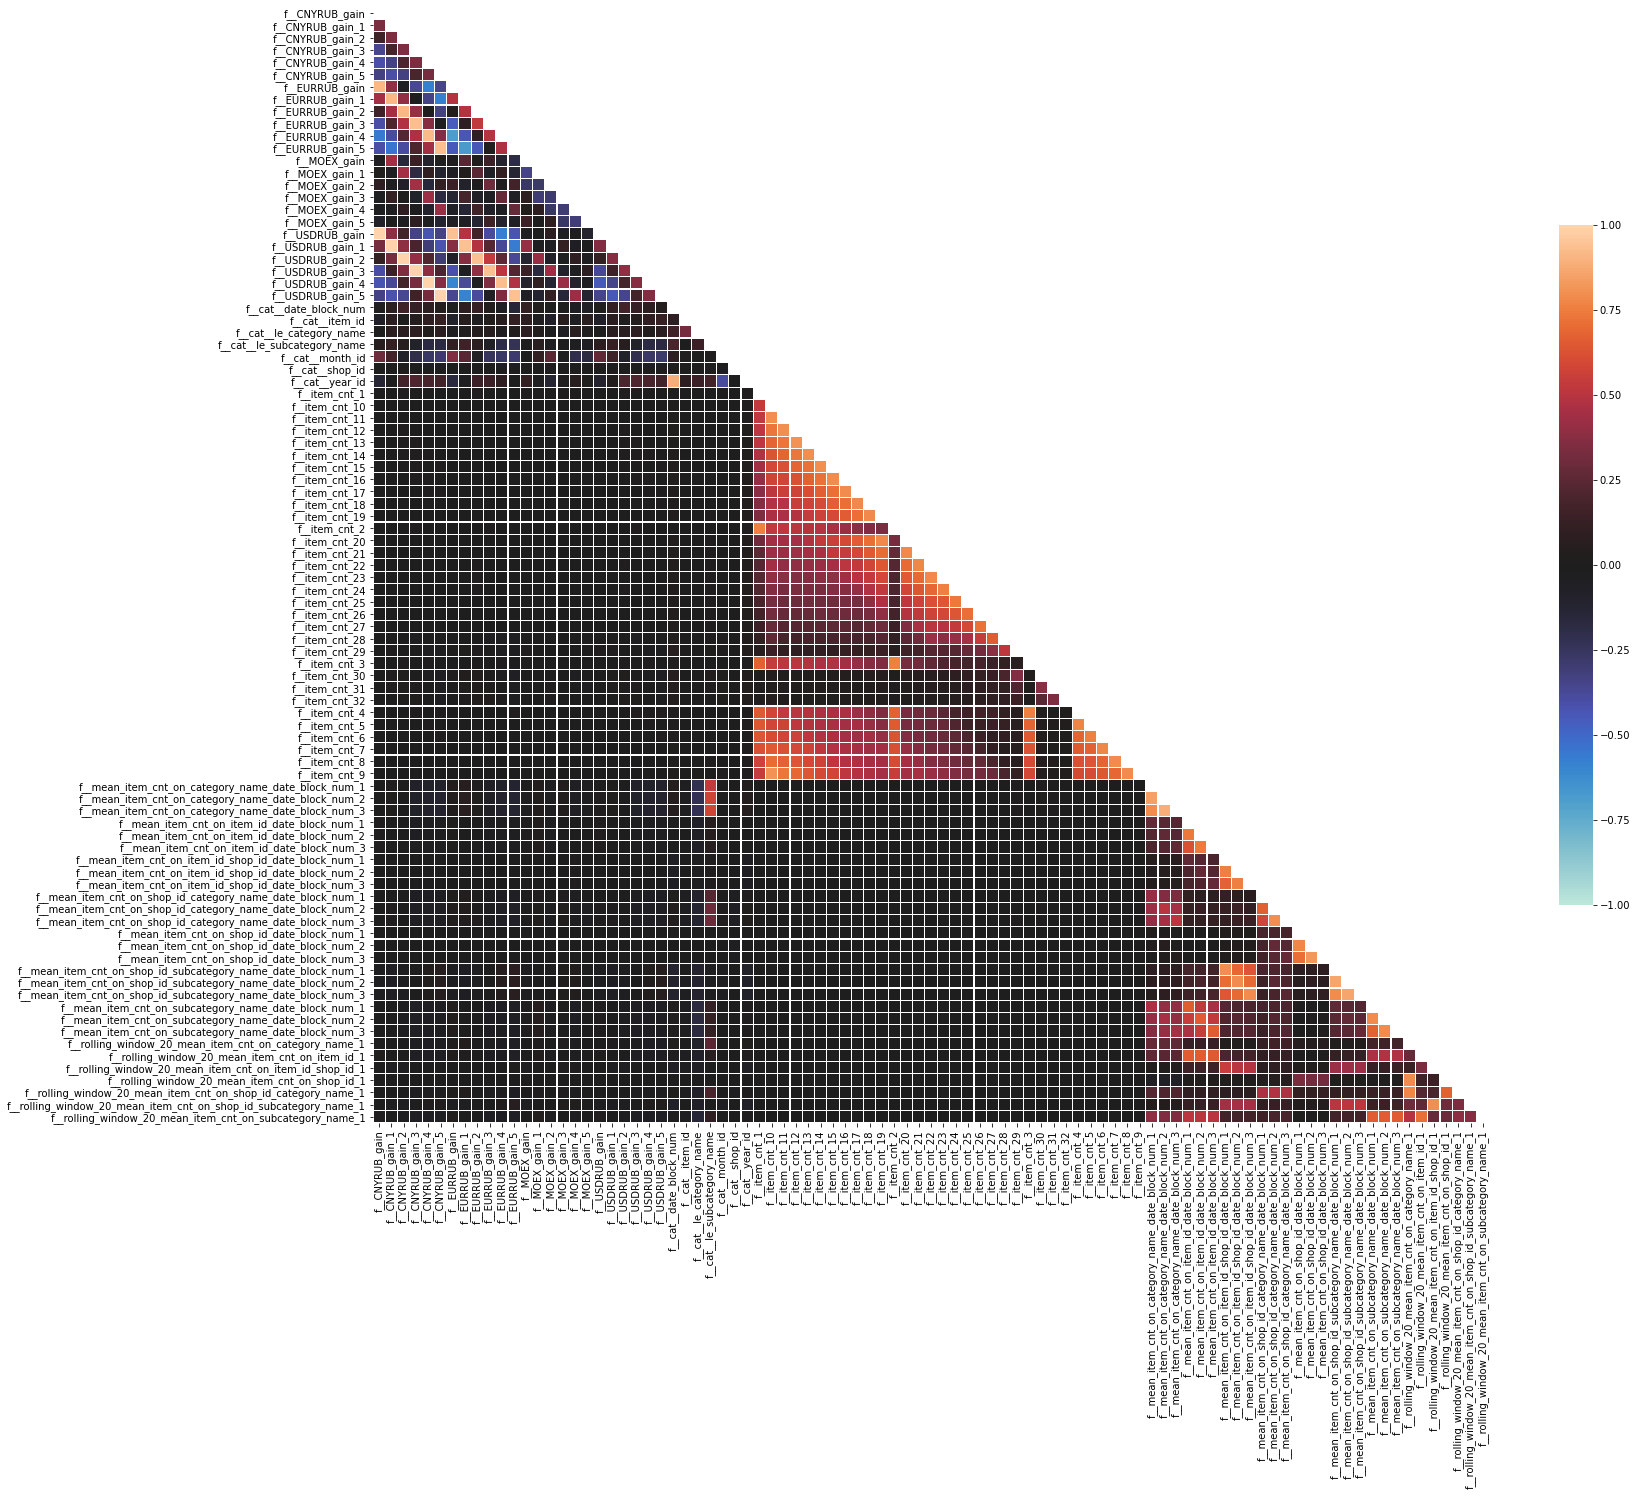

In [23]:
features_corr = drop_non_features(train_set_005).corr()
features_corr = features_corr.reindex(sorted(features_corr.columns), axis=1)
features_corr.sort_index(inplace=True)
corr_plot(features_corr, figsize=(25, 25))

Ok, we can see clear clusters of highly correlated features. Let's start by looking at `item_cnt` features. 

In [19]:
item_cnt_corr = train_set_005[[c for c in train_set_005.columns
                               if c.startswith('f__item_cnt_')]].corr()

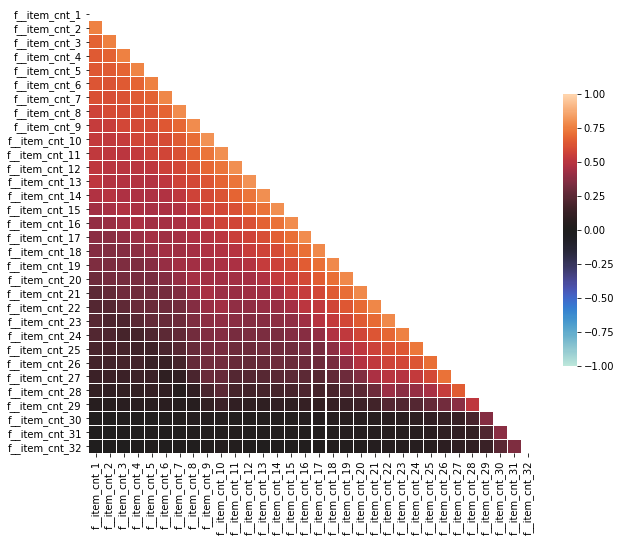

In [24]:
corr_plot(item_cnt_corr)

They look highly correlated, except the last ones. Just like the time window, let's test how the lag size affects the CV score.

Again it doesn't really after a window, but it also doesn't degrade the model that much. I'll keep it as it is for now.

The other clear cluster is the economy indicators, but I'll take a look at them in the next experiment.

# Lower score feature sets

From the validation data we see that two feature sets stand out being the worst performant: the baseline (000) and the economy indicators (004). Let's try dropping features from both.

In [6]:

feature_cols_000 = drop_non_features(pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'train-set-features-000.parquet'))).columns
feature_cols_004 = drop_non_features(pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'train-set-features-004.parquet'))).columns
feature_cols_000_004 = np.concatenate([feature_cols_000, feature_cols_004])
feature_cols_000_004

array(['f__cat__item_id', 'f__cat__shop_id', 'f__cat__date_block_num',
       'f__cat__item_id', 'f__cat__shop_id', 'f__cat__date_block_num',
       'f__MOEX_gain_1', 'f__CNYRUB_gain_1', 'f__USDRUB_gain_1',
       'f__EURRUB_gain_1', 'f__MOEX_gain_2', 'f__CNYRUB_gain_2',
       'f__USDRUB_gain_2', 'f__EURRUB_gain_2', 'f__MOEX_gain_3',
       'f__CNYRUB_gain_3', 'f__USDRUB_gain_3', 'f__EURRUB_gain_3',
       'f__MOEX_gain_4', 'f__CNYRUB_gain_4', 'f__USDRUB_gain_4',
       'f__EURRUB_gain_4', 'f__MOEX_gain_5', 'f__CNYRUB_gain_5',
       'f__USDRUB_gain_5', 'f__EURRUB_gain_5', 'f__MOEX_gain',
       'f__CNYRUB_gain', 'f__USDRUB_gain', 'f__EURRUB_gain'], dtype=object)

In [10]:
validate(train_set_005.drop(columns=[c for c in train_set_005.columns if c in feature_cols_000]), verbose=0)
validate(train_set_005.drop(columns=[c for c in train_set_005.columns if c in feature_cols_004]), verbose=0)
validate(train_set_005.drop(columns=[c for c in train_set_005.columns if c in feature_cols_000_004]), verbose=0)

RMSE: -0.85950 (+- 0.06352)
RMSE: -0.85970 (+- 0.06169)
RMSE: -0.85970 (+- 0.06169)


{'fit_time': array([14.9257226 , 16.38920856, 50.65873742]),
 'score_time': array([0.95938134, 0.96582794, 0.97239447]),
 'test_score': array([-0.77439418, -0.91818106, -0.88651026])}

It improved without the ones from feature set 000, but not by a lot.

# Putting it all together

We saw some minor improvements on each of our experiments. Let's just put everything together and see what we get.

In [13]:
lag_lim = 15
time_window = 15

cols_to_drop = np.concatenate([
    feature_cols_000,['f__item_cnt_%d' % i for i in range(lag_lim, 33)]])

train_set_modified = train_set_005.drop(columns=cols_to_drop)

In [15]:
scores = validate(train_set_modified, cv_splits=tscv.split(train_set_modified['date_block_num']))
scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  17.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s


[CV] ................................................. , total=  18.5s
[CV]  ................................................................
[CV] ................................................. , total=  20.2s
RMSE: -0.85994 (+- 0.06513)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   56.3s finished


{'fit_time': array([16.5730505 , 17.37322569, 19.13831949]),
 'score_time': array([1.03013635, 1.11692929, 1.0850513 ]),
 'test_score': array([-0.77033451, -0.92321767, -0.8862669 ])}